# RICERCA NON INFORMATA

#### Librerie utilizzate

In [2]:
import osmnx as ox
import folium
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import heapq
import time
import sys
from geopy.distance import geodesic
import contextily as ctx


#### ESTRAZIONE DELLA RETE STRADALE DI BARI nel grafo G

In [ ]:
#Estrazione della rete stradale di Bari
G = ox.graph_from_place("Bari, Italy", network_type="drive", simplify=True)

#Salvare la rete in formato GraphML
ox.save_graphml(G, "rete_bari.graphml")

#### Plot del grafo

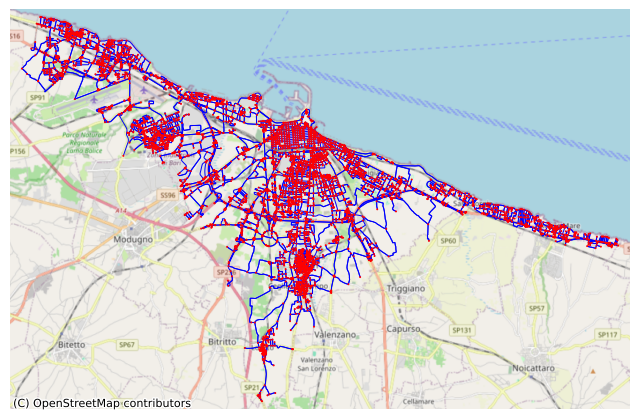

In [38]:
# Carica il grafo
G = ox.load_graphml("rete_bari.graphml")

# Plotta il grafo senza chiudere la figura
fig, ax = ox.plot_graph(G, node_size=2, edge_linewidth=0.7, edge_color="blue", node_color="red", show=False, close=False)

# Aggiungi la mappa di sfondo
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=G.graph['crs'])

# Mostra la figura
plt.show()


#### **Aggiunta numero incidenti sui segmenti stradali**

Sfruttando il dataset **"Dati_aggregati"**, dove per ogni segmento stradale sono presenti il *numero di incidenti* avvenuti, aggiorno gli archi del grafo G con questa informazione

In [ ]:
df = pd.read_csv(".\\Dati\\Dati_aggregati.csv")

incidenti_dict = df.groupby("ID_Segmento")["NUM_INCIDENTI"].sum().to_dict()

for u, v, k, data in G.edges(data=True, keys=True):
    if "osmid" in data:
        osmids = data["osmid"]

        if isinstance(osmids, list):
            incidenti_count = sum(incidenti_dict.get(osmid, 0) for osmid in osmids)
        else:
            incidenti_count = incidenti_dict.get(osmids, 0)

        data["incidenti"] = incidenti_count

ox.save_graphml(G, "rete_bari_incidenti.graphml")
print("Grafo salvato con successo")

#### Script utile a trovare il nodo più vicino a delle coordinate inserite

In [4]:
def get_nearest_node(graph, x, y):
    """Trova il nodo più vicino alle coordinate (x, y) nel grafo."""
    nearest_node = ox.distance.nearest_nodes(graph, X=x, Y=y)
    
    # Ottenere le coordinate del nodo più vicino
    nodes, _ = ox.graph_to_gdfs(graph)
    node_coords = nodes.loc[nearest_node].geometry
    
    return nearest_node, node_coords.y, node_coords.x

# Caricare il grafo di Bari
G = ox.load_graphml("rete_bari_incidenti.graphml")

# Inserire le coordinate di input
x_input = 16.8548679  # Esempio di longitudine   
y_input = 41.1251951  # Esempio di latitudine

# Trovare il nodo più vicino
node_id, lat, lon = get_nearest_node(G, x_input, y_input)

print(f"Nodo più vicino trovato: ID = {node_id}, Latitudine = {lat}, Longitudine = {lon}")



Nodo più vicino trovato: ID = 1481415203, Latitudine = 41.1252559, Longitudine = 16.8548615


## Ricerca con Iterative-Deepening

In [5]:
def dls(graph, start, goal, depth, explored_paths):
    """Ricerca in profondità limitata"""
    stack = [(start, [start])]
    
    while stack:
        node, path = stack.pop()
        explored_paths.append(path)  # Salvare il percorso esplorato
        
        if node == goal:
            return path  # Ritorna il percorso trovato
        
        if len(path) - 1 < depth:  # Controllo della profondità
            for neighbor in graph.neighbors(node):
                if neighbor not in path:
                    stack.append((neighbor, path + [neighbor]))
    
    return None  # Nessun percorso trovato entro la profondità

def iterative_deepening_dfs(graph, start, goal, max_depth=22):
    explored_paths = []
    start_time = time.time()
    memory_before = sys.getsizeof(explored_paths)
    
    for depth in range(max_depth):
        result = dls(graph, start, goal, depth, explored_paths)
        if result:
            execution_time = time.time() - start_time
            memory_after = sys.getsizeof(explored_paths)
            memory_used = memory_after - memory_before
            return result, explored_paths, depth, execution_time, memory_used  # Restituisce il percorso, profondità, tempo e memoria
    
    execution_time = time.time() - start_time
    memory_after = sys.getsizeof(explored_paths)
    memory_used = memory_after - memory_before
    return None, explored_paths, max_depth, execution_time, memory_used  # Nessun percorso trovato

# Caricare il grafo di Bari
G = ox.load_graphml("rete_bari_incidenti.graphml")

partenza = 270659688
arrivo = 1481415203

# Trovare il percorso più breve tra i due nodi e raccogliere statistiche
shortest_path, explored_paths, depth_reached, exec_time, memory_used = iterative_deepening_dfs(G, partenza, arrivo)

if shortest_path:
    print(f"Percorso più breve trovato: {shortest_path}")
    print(f"Profondità raggiunta: {depth_reached}")
    print(f"Percorsi esplorati: {len(explored_paths)}")
    print(f"Tempo di esecuzione: {exec_time:.4f} secondi")
    print(f"Memoria utilizzata: {memory_used} byte")
else:
    print("Nessun percorso trovato.")
    print(f"Profondità raggiunta: {depth_reached}")
    print(f"Tempo di esecuzione: {exec_time:.4f} secondi")
    print(f"Memoria utilizzata: {memory_used} byte")

Percorso più breve trovato: [270659688, 270388628, 322548994, 322549051, 322550079, 322549607, 322550392, 322550761, 320970977, 330655154, 330655155, 270388358, 320971935, 320971934, 270437927, 353330854, 270389790, 329988604, 329988602, 270655174, 270654641, 1481415203]
Profondità raggiunta: 21
Percorsi esplorati: 63991
Tempo di esecuzione: 0.0499 secondi
Memoria utilizzata: 562432 byte


### Ottimizzazione dell'algoritmo IDDFS: Riduzione delle riesplorazioni ridondanti

#### **Problematica**
L'algoritmo **Iterative Deepening Depth-First Search (IDDFS)**, nella sua implementazione standard, può riesplorare più volte lo stesso nodo con percorsi di lunghezza maggiore rispetto a quelli già individuati. Questa caratteristica comporta un incremento del numero di iterazioni, del tempo di esecuzione e dell'uso della memoria, soprattutto in grafi di grandi dimensioni.

#### **Soluzione Implementata**
Per ottimizzare l'algoritmo, è stato introdotto un **dizionario `visited`**, che tiene traccia della profondità minima a cui ogni nodo è stato raggiunto. Il comportamento dell'algoritmo è stato modificato nel seguente modo:
- Se un nodo viene raggiunto con una profondità maggiore rispetto a quella con cui era stato precedentemente visitato, viene **ignorato**.
- Se un nodo viene raggiunto per la **prima volta** o con una **profondità inferiore**, la sua profondità viene aggiornata in `visited[node]`, garantendo che l'algoritmo utilizzi sempre il percorso più breve disponibile.

#### **Benefici dell'Ottimizzazione**
- **Riduzione del numero di riesplorazioni**, evitando di considerare percorsi subottimali.  
- **Miglioramento del tempo di esecuzione**, specialmente in grafi di grandi dimensioni.  
- **Ottimizzazione dell'uso della memoria**, limitando la crescita dello stack di ricerca.  
- **Mantenimento della correttezza dell'algoritmo**, preservando la capacità di individuare il percorso minimo.

L'ottimizzazione implementata consente di ottenere una versione più **efficiente e scalabile** dell'algoritmo IDDFS, particolarmente adatta per l'esplorazione di grafi di grandi dimensioni e applicazioni real-time.


In [ ]:
def dls(graph, start, goal, depth, explored_paths, visited):
    """Ricerca in profondità limitata (DLS) per IDDFS evitando riesplorazioni."""
    stack = [(start, [start])]
    
    while stack:
        node, path = stack.pop()
        
        if node in visited and len(path) - 1 > visited[node]:
            continue  # Se il nodo è già stato visitato con un percorso più breve, lo saltiamo
        
        visited[node] = len(path) - 1  # Aggiorniamo il livello minimo raggiunto per questo nodo
        explored_paths.append(path)  # Salvare il percorso esplorato
        
        if node == goal:
            return path  # Ritorna il percorso trovato
        
        if len(path) - 1 < depth:  # Controllo della profondità
            for neighbor in graph.neighbors(node):
                if neighbor not in path:
                    stack.append((neighbor, path + [neighbor]))
    
    return None  # Nessun percorso trovato entro la profondità

def iterative_deepening_dfs(graph, start, goal, max_depth=50):
    """Iterative Deepening DFS per trovare il percorso più breve tra due nodi evitando riesplorazioni."""
    explored_paths = []
    start_time = time.time()
    memory_before = sys.getsizeof(explored_paths)
    
    visited = {}  # Dizionario per tracciare la profondità minima raggiunta per ogni nodo
    
    for depth in range(max_depth):
        result = dls(graph, start, goal, depth, explored_paths, visited)
        if result:
            execution_time = time.time() - start_time
            memory_after = sys.getsizeof(explored_paths)
            memory_used = memory_after - memory_before
            return result, explored_paths, depth, execution_time, memory_used  # Restituisce il percorso, profondità, tempo e memoria
    
    execution_time = time.time() - start_time
    memory_after = sys.getsizeof(explored_paths)
    memory_used = memory_after - memory_before
    return None, explored_paths, max_depth, execution_time, memory_used  # Nessun percorso trovato

# Caricare il grafo di Bari
G = ox.load_graphml("rete_bari_incidenti.graphml")

partenza = 270659688
arrivo = 1481415203

# Trovare il percorso più breve tra i due nodi e raccogliere statistiche
shortest_path, explored_paths, depth_reached, exec_time, memory_used = iterative_deepening_dfs(G, partenza, arrivo)

if shortest_path:
    print(f"Percorso più breve trovato: {shortest_path}")
    print(f"Profondità raggiunta: {depth_reached}")
    print(f"Percorsi esplorati: {len(explored_paths)}")
    print(f"Tempo di esecuzione: {exec_time:.4f} secondi")
    print(f"Memoria utilizzata: {memory_used} byte")
else:
    print("Nessun percorso trovato.")
    print(f"Profondità raggiunta: {depth_reached}")
    print(f"Tempo di esecuzione: {exec_time:.4f} secondi")
    print(f"Memoria utilizzata: {memory_used} byte")

Percorso più breve trovato: [270659688, 270388628, 322548994, 322549051, 322550079, 322549607, 322550392, 322550761, 320970977, 330655154, 330655155, 270388358, 320971935, 320971934, 270437927, 353330854, 270389790, 329988604, 329988602, 270655174, 270654641, 1481415203]
Profondità raggiunta: 21
Percorsi esplorati: 8020
Tempo di esecuzione: 0.0126 secondi
Memoria utilizzata: 67168 byte


## PLOT DEI PERCORSI TROVATI

In [30]:
def plot_paths_on_map(graph, shortest_path, explored_paths, start, goal):
    """Visualizza tutti i percorsi esplorati e il percorso più breve sulla mappa."""
    nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
    center = (nodes.loc[start].geometry.y, nodes.loc[start].geometry.x)
    
    mappa = folium.Map(location=center, zoom_start=13)
    
    # Disegnare tutti i percorsi esplorati in blu
    for path in explored_paths:
        path_coords = [(nodes.loc[node].geometry.y, nodes.loc[node].geometry.x) for node in path]
        folium.PolyLine(path_coords, color="blue", weight=3, opacity=0.5).add_to(mappa)
    
    # Disegnare il percorso più breve in rosso sopra il blu
    if shortest_path:
        path_coords = [(nodes.loc[node].geometry.y, nodes.loc[node].geometry.x) for node in shortest_path]
        folium.PolyLine(path_coords, color="red", weight=6, opacity=0.9).add_to(mappa)
    
    # Aggiungere marker per il punto di partenza e di arrivo
    folium.Marker(
        location=(nodes.loc[start].geometry.y, nodes.loc[start].geometry.x),
        popup="Partenza",
        icon=folium.Icon(color="green", icon="play")
    ).add_to(mappa)
    
    folium.Marker(
        location=(nodes.loc[goal].geometry.y, nodes.loc[goal].geometry.x),
        popup="Arrivo",
        icon=folium.Icon(color="red", icon="flag")
    ).add_to(mappa)
    
    return mappa

mappa = plot_paths_on_map(G, shortest_path, explored_paths, partenza, arrivo)
mappa.save("percorso_IDDFS.html")